In [1]:
import sys
import os
import shutil
import json
import ast

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
import seaborn as sns
sns.set_style("whitegrid")

import tensorflow as tf
print("tensorflow:", tf.__version__)
from tensorflow import keras
print("keras:", keras.__version__)
import keras_tuner as kt
print("keras_tuner:", kt.__version__)

from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Check if tensorflow can use your GPU
tf.config.list_physical_devices('GPU')

2022-07-27 16:13:35.407543: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


tensorflow: 2.9.1
keras: 2.9.0
keras_tuner: 1.1.3


2022-07-27 16:13:36.393651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:13:36.397819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:13:36.398016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
# Do prediction with the best hpars of current partition or AroAdm partition

# which_hps = part
which_hps = "AroAdm"
print(which_hps)

AroAdm


In [16]:
# Random_state seed
RS = 1234

In [17]:
# 1. Obtain parameters for the different analyses ----------------------------------------
par_file = sys.argv[1]
row_number = int(sys.argv[2])

# par_file = "AroAdm_kerPC.csv"
# par_file = "AroAdm_top-markers-10k.csv"
# row_number = 2

# Load grid
par_grid = pd.read_csv(os.path.join("parameters", par_file))
par_grid

,model_type,architecture,m_set,traits,part,input_type,output_type
0,top-markers-10k,MLP,SNP,culm.diameter.1st.internode,AroAdm,single-input,single-output
1,top-markers-10k,MLP,SNP,leaf.senescence,AroAdm,single-input,single-output
2,top-markers-10k,MLP,SNP,grain.weight,AroAdm,single-input,single-output
3,top-markers-10k,MLP,SNP,time.to.flowering.from.sowing,AroAdm,single-input,single-output
4,top-markers-10k,MLP,all,culm.diameter.1st.internode,AroAdm,single-input,single-output
5,top-markers-10k,MLP,all,leaf.senescence,AroAdm,single-input,single-output
6,top-markers-10k,MLP,all,grain.weight,AroAdm,single-input,single-output
7,top-markers-10k,MLP,all,time.to.flowering.from.sowing,AroAdm,single-input,single-output
8,top-markers-10k,CNN,SNP,culm.diameter.1st.internode,AroAdm,single-input,single-output
9,top-markers-10k,CNN,SNP,leaf.senescence,AroAdm,single-input,single-output


In [18]:
# Extract parameters =====================================================================

# Which row of the grid
pars = par_grid.iloc[row_number]
print(pars, "\n")

# Model type: top-markers-10k or kerPC
model_type = pars["model_type"]

# Common pars
architecture = pars["architecture"]
m_set = pars["m_set"]
traits = pars["traits"]
part = pars["part"]
input_type = pars["input_type"]
output_type = pars["output_type"]

# Output folder
out_folder = os.path.join("models", f"{model_type}_{architecture}_{m_set}_{input_type}", traits, part)
if not os.path.isdir(out_folder):
    os.makedirs(out_folder)
print(out_folder)

# Save traits as list
# If multi-output, change literal string to list
if output_type == "multi-output":
    traits = ast.literal_eval(traits)
else:
    traits = [traits]
print(traits)

# Target variable type
# Save as list, just like traits
target_dict = {
    "culm.diameter.1st.internode": "binary",
    "leaf.senescence": "binary",
    "grain.weight": "continuous",
    "time.to.flowering.from.sowing": "continuous"
}

target_types = []
for trait_i in traits:
    if trait_i not in target_dict.keys():
        print("Define variable type of the target in the dictionary")
        exit(1)
    target_types.append(target_dict[trait_i])

print(target_types)

model_type      top-markers-10k
architecture                MLP
m_set                       SNP
traits             grain.weight
part                     AroAdm
input_type         single-input
output_type       single-output
Name: 2, dtype: object 

models/top-markers-10k_MLP_SNP_single-input/grain.weight/AroAdm
['grain.weight']
['continuous']


In [19]:
# 3. Prepare data ------------------------------------------------------------------------

# Features ===============================================================================
# Generate X_list, even if single-input

# Top-markers-10k
if model_type == "top-markers-10k":
    X_list = []
    X_scaler_list = []
    
    # For every trait, 10k most associated markers
    for i in range(len(traits)):
        X_name = f"geno_top-10000-{m_set}_{part}_{traits[i]}.csv"
        # Load and remove accession column
        X_df = pd.read_csv(os.path.join("data", model_type, X_name))
        X_df = X_df.iloc[:, 1:]
        
        X = X_df.to_numpy()
        # Scale using all data because genomic prediction
        scaler_X_all = StandardScaler()
        scaler_X_all.fit(X)
        X = scaler_X_all.transform(X)
        
        X_list.append(X)
        X_scaler_list.append(scaler_X_all)
        
# kerPC
elif model_type == "kerPC":
    # Save initial list with kerPCs based on marker set
    X_list_initial = []
    
    # Define marker sets
    if m_set == "SNP":
        marker_sets = ["SNP"]
    elif m_set == "all":
        marker_sets = ["DEL", "DUP", "INV", "MITE-DTX", "RLX-RIX", "SNP"]
    
    # Load matrices
    for i in range(len(marker_sets)):
        X_name = f"PC_{marker_sets[i]}.csv"
        X_df = pd.read_csv(os.path.join("data", model_type, X_name))
        X_df = X_df.iloc[:, 1:]
        
        X = X_df.to_numpy()
        X_list_initial.append(X)
    
    # Process depending on input-type
    X_list = []
    X_scaler_list = []
    
    # If single-input, concatenate matrices of list
    if input_type == "single-input":
        for i in range(len(X_list_initial)):
            if i == 0:
                X = X_list_initial[i]
                continue
            
            X = np.concatenate((X, X_list_initial[i]), axis = 1)
        
        # Scale using all data because genomic prediction
        scaler_X_all = StandardScaler()
        scaler_X_all.fit(X)
        X = scaler_X_all.transform(X)
        
        X_list.append(X)
        X_scaler_list.append(scaler_X_all)
    # Multi-input
    else:
        for i in range(len(X_list_initial)):
            X = X_list_initial[i]
            
            # Scale using all data because genomic prediction
            scaler_X_all = StandardScaler()
            scaler_X_all.fit(X)
            X = scaler_X_all.transform(X)
            
            X_list.append(X)
            X_scaler_list.append(scaler_X_all)

print(len(X_list))
print(X_list[0].shape)

1
(738, 10000)


In [20]:
# Target =================================================================================

Y_df = pd.read_csv(os.path.join("data", "pheno_original.csv"))
parts = pd.read_csv(os.path.join("data", "partitions.csv"))

# Obtain train and test masks ############################################################
# Single-output
if output_type == "single-output":
    y_df = Y_df[traits[0]]
    y = y_df.to_numpy().reshape(-1, 1)

    train_mask = (parts[part] == "train") & pd.notna(y_df)
    test_mask = (parts[part] == "test") & pd.notna(y_df)
# Multi-output
else:
    # Obtain combined mask of missing values for the different traits (final_NA_mask)
    NA_mask_list = []
    for i in range(len(traits)):
        y_df = Y_df[traits[i]]
        
        NA_mask = pd.notna(y_df)
        NA_mask_list.append(NA_mask)
    
    for i in range(len(NA_mask_list)):
        if i == 0:
            final_NA_mask = NA_mask_list[i]
            continue
        final_NA_mask = final_NA_mask & NA_mask_list[i]
        # print(initial_mask_list[i].sum())
        print(final_NA_mask.sum())
    
    train_mask = (parts[part] == "train") & final_NA_mask
    test_mask = (parts[part] == "test") & final_NA_mask
    
print(train_mask.sum(), test_mask.sum())

# Train / test split + train_sub / validation split ######################################

# Dicts of y splits for each trait (output)
y_train = {}; y_test = {}; y_train_sub = {}; y_val = {}
# y_train_scaler_dict = {}

for i in range(len(traits)):
    y_df = Y_df[traits[i]]
    y = y_df.to_numpy().reshape(-1, 1)
    
    key = traits[i]
    
    # 1. Target split
    
    y_train_i = y[train_mask, ]
    y_test_i = y[test_mask, ]
    
    # 2. Target process

    # Scale continuous targets (just with train data)
    # We no longer scale targets
    if target_types[i] == "continuous":
        # scaler_y_train = StandardScaler()
        # scaler_y_train.fit(y_train_i)
        # y_train_i = scaler_y_train.transform(y_train_i)
        # y_test_i = scaler_y_train.transform(y_test_i)
        
        # y_train_scaler_dict[key] = scaler_y_train
        pass
    # Recode binary targets from 1/2 to 0/1
    elif target_types[i] == "binary":
        y_train_i = np.where(y_train_i == 2, 1, 0)
        y_test_i = np.where(y_test_i == 2, 1, 0)
    else:
        print("Unknown target variable type")
        exit(1)
    
    y_train[key] = y_train_i
    y_test[key] = y_test_i
    
    # 3. Features split
    
    X_train = []
    X_test = []
    
    X_train_sub = []
    X_val = []
    
    # For every input
    for j in range(len(X_list)):
        X_train.append(X_list[j][train_mask, ])
        X_test.append(X_list[j][test_mask, ])
        
        # RS seed is important in this case to have the same splits
        X_train_sub_i, X_val_i, y_train_sub_i, y_val_i = train_test_split(
            X_train[j], y_train_i,
            test_size = 0.2,
            random_state = RS
        )
        X_train_sub.append(X_train_sub_i)
        X_val.append(X_val_i)
    
    y_train_sub[key] = y_train_sub_i
    y_val[key] = y_val_i

# X_lists and y_dicts
print(len(X_train), len(y_train.keys()))

print(X_train[0].shape, X_test[0].shape, X_train_sub[0].shape, X_val[0].shape)
print(y_train[traits[0]].shape, y_test[traits[0]].shape,
      y_train_sub[traits[0]].shape, y_val[traits[0]].shape)

607 34
1 1
(607, 10000) (34, 10000) (485, 10000) (122, 10000)
(607, 1) (34, 1) (485, 1) (122, 1)


In [21]:
# 4. Load hypermodels and create corresponding object ------------------------------------

from hypermodels import hyper_MLP
from hypermodels import hyper_CNN

In [22]:
input_dim = (X_train[0].shape[1], )
n_inputs = len(X_train)
n_outputs = len(traits)
print(input_dim, traits, target_types, n_inputs, n_outputs)


if architecture == "MLP":
    hypermodel = hyper_MLP(
        input_dim = input_dim, targets = traits, target_types = target_types,
        n_inputs = n_inputs, n_outputs = n_outputs
    )
elif architecture == "CNN":
    hypermodel = hyper_CNN(
        input_dim = input_dim, targets = traits, target_types = target_types,
        n_inputs = n_inputs, n_outputs = n_outputs
    )

(10000,) ['grain.weight'] ['continuous'] 1 1


In [23]:
# model = hypermodel.build(kt.HyperParameters())
# model.summary()
# history = model.fit(x = X_train, y = y_train, epochs = 10, validation_data = (X_val, y_val))
# model.evaluate(x = X_test, y = y_test, return_dict = True)

In [24]:
# 5. Prediction --------------------------------------------------------------------------

# Load best hpars ========================================================================

# Do prediction with the best hpars of current partition or AroAdm partition
print(which_hps)

trait_path = os.path.dirname(out_folder)
hps_path = os.path.join(trait_path, which_hps, "top_hps")
print(hps_path)

# Load dictionary of best hpars
with open(os.path.join(hps_path, f"top_hps_{1}.json"), "r") as infile:
    hps_dict = json.load(infile)
print(hps_dict)

# Create hpar object from dictionary
best_hps = kt.HyperParameters()
best_hps.values = hps_dict

# Results path: different folder than hypermodel results #################################
pred_path = os.path.join(trait_path, part, f"results_hps_{which_hps}")
if not os.path.isdir(pred_path):
    os.mkdir(pred_path)
##########################################################################################

AroAdm
models/top-markers-10k_MLP_SNP_single-input/grain.weight/AroAdm/top_hps


FileNotFoundError: [Errno 2] No such file or directory: 'models/top-markers-10k_MLP_SNP_single-input/grain.weight/AroAdm/top_hps/top_hps_1.json'

Epoch 1/50


2022-07-27 16:13:50.879188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 16:13:50.879777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:13:50.880074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:13:50.880197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

16/16 - 1s - loss: 2.1868 - mse: 2.1868 - val_loss: 0.7451 - val_mse: 0.7451 - 859ms/epoch - 54ms/step
Epoch 2/50
16/16 - 0s - loss: 0.3783 - mse: 0.3783 - val_loss: 0.3084 - val_mse: 0.3084 - 57ms/epoch - 4ms/step
Epoch 3/50
16/16 - 0s - loss: 0.1697 - mse: 0.1697 - val_loss: 0.2469 - val_mse: 0.2469 - 59ms/epoch - 4ms/step
Epoch 4/50
16/16 - 0s - loss: 0.1054 - mse: 0.1054 - val_loss: 0.2747 - val_mse: 0.2747 - 59ms/epoch - 4ms/step
Epoch 5/50
16/16 - 0s - loss: 0.0874 - mse: 0.0874 - val_loss: 0.2422 - val_mse: 0.2422 - 57ms/epoch - 4ms/step
Epoch 6/50
16/16 - 0s - loss: 0.0476 - mse: 0.0476 - val_loss: 0.2021 - val_mse: 0.2021 - 55ms/epoch - 3ms/step
Epoch 7/50
16/16 - 0s - loss: 0.0305 - mse: 0.0305 - val_loss: 0.2033 - val_mse: 0.2033 - 82ms/epoch - 5ms/step
Epoch 8/50
16/16 - 0s - loss: 0.0259 - mse: 0.0259 - val_loss: 0.2025 - val_mse: 0.2025 - 52ms/epoch - 3ms/step
Epoch 9/50
16/16 - 0s - loss: 0.0199 - mse: 0.0199 - val_loss: 0.1993 - val_mse: 0.1993 - 54ms/epoch - 3ms/step
E

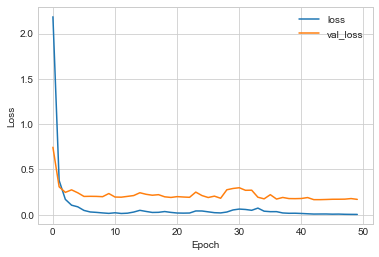

2/2 [==============================] - 0s 2ms/step
Epoch 1/50
16/16 - 0s - loss: 1.5537 - mse: 1.5537 - val_loss: 0.5320 - val_mse: 0.5320 - 474ms/epoch - 30ms/step
Epoch 2/50
16/16 - 0s - loss: 1.1782 - mse: 1.1782 - val_loss: 0.7391 - val_mse: 0.7391 - 83ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 0.3079 - mse: 0.3079 - val_loss: 0.2245 - val_mse: 0.2245 - 56ms/epoch - 3ms/step
Epoch 4/50
16/16 - 0s - loss: 0.1183 - mse: 0.1183 - val_loss: 0.2155 - val_mse: 0.2155 - 57ms/epoch - 4ms/step
Epoch 5/50
16/16 - 0s - loss: 0.0752 - mse: 0.0752 - val_loss: 0.2492 - val_mse: 0.2492 - 72ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 0.1038 - mse: 0.1038 - val_loss: 0.3264 - val_mse: 0.3264 - 52ms/epoch - 3ms/step
Epoch 7/50
16/16 - 0s - loss: 0.0518 - mse: 0.0518 - val_loss: 0.1523 - val_mse: 0.1523 - 58ms/epoch - 4ms/step
Epoch 8/50
16/16 - 0s - loss: 0.0374 - mse: 0.0374 - val_loss: 0.1905 - val_mse: 0.1905 - 53ms/epoch - 3ms/step
Epoch 9/50
16/16 - 0s - loss: 0.0237 - mse: 0.0237 

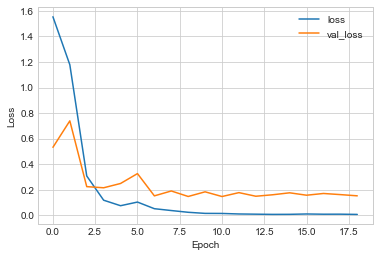

2/2 [==============================] - 0s 2ms/step
Epoch 1/50
16/16 - 0s - loss: 2.1423 - mse: 2.1423 - val_loss: 0.4806 - val_mse: 0.4806 - 418ms/epoch - 26ms/step
Epoch 2/50
16/16 - 0s - loss: 0.3566 - mse: 0.3566 - val_loss: 0.1788 - val_mse: 0.1788 - 84ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 0.1540 - mse: 0.1540 - val_loss: 0.1792 - val_mse: 0.1792 - 52ms/epoch - 3ms/step
Epoch 4/50
16/16 - 0s - loss: 0.0964 - mse: 0.0964 - val_loss: 0.1454 - val_mse: 0.1454 - 55ms/epoch - 3ms/step
Epoch 5/50
16/16 - 0s - loss: 0.0650 - mse: 0.0650 - val_loss: 0.1484 - val_mse: 0.1484 - 52ms/epoch - 3ms/step
Epoch 6/50
16/16 - 0s - loss: 0.0479 - mse: 0.0479 - val_loss: 0.2077 - val_mse: 0.2077 - 53ms/epoch - 3ms/step
Epoch 7/50
16/16 - 0s - loss: 0.0307 - mse: 0.0307 - val_loss: 0.1407 - val_mse: 0.1407 - 64ms/epoch - 4ms/step
Epoch 8/50
16/16 - 0s - loss: 0.0471 - mse: 0.0471 - val_loss: 0.2209 - val_mse: 0.2209 - 54ms/epoch - 3ms/step
Epoch 9/50
16/16 - 0s - loss: 0.0470 - mse: 0.0470 

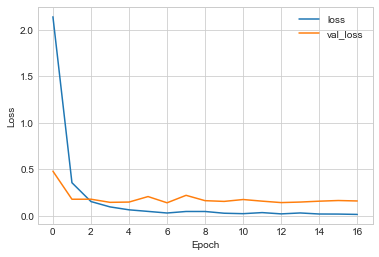

2/2 [==============================] - 0s 2ms/step
Epoch 1/50
16/16 - 0s - loss: 1.9821 - mse: 1.9821 - val_loss: 0.4092 - val_mse: 0.4092 - 417ms/epoch - 26ms/step
Epoch 2/50
16/16 - 0s - loss: 0.4569 - mse: 0.4569 - val_loss: 0.3213 - val_mse: 0.3213 - 70ms/epoch - 4ms/step
Epoch 3/50
16/16 - 0s - loss: 0.2077 - mse: 0.2077 - val_loss: 0.2258 - val_mse: 0.2258 - 53ms/epoch - 3ms/step
Epoch 4/50
16/16 - 0s - loss: 0.1370 - mse: 0.1370 - val_loss: 0.1862 - val_mse: 0.1862 - 53ms/epoch - 3ms/step
Epoch 5/50
16/16 - 0s - loss: 0.0726 - mse: 0.0726 - val_loss: 0.2396 - val_mse: 0.2396 - 56ms/epoch - 4ms/step
Epoch 6/50
16/16 - 0s - loss: 0.0773 - mse: 0.0773 - val_loss: 0.2515 - val_mse: 0.2515 - 53ms/epoch - 3ms/step
Epoch 7/50
16/16 - 0s - loss: 0.0620 - mse: 0.0620 - val_loss: 0.2299 - val_mse: 0.2299 - 52ms/epoch - 3ms/step
Epoch 8/50
16/16 - 0s - loss: 0.0603 - mse: 0.0603 - val_loss: 0.1881 - val_mse: 0.1881 - 54ms/epoch - 3ms/step
Epoch 9/50
16/16 - 0s - loss: 0.0661 - mse: 0.0661 

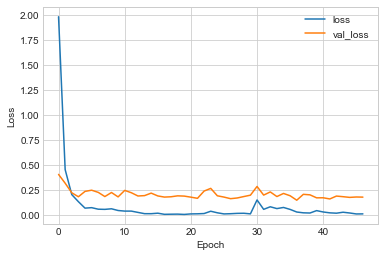

2/2 [==============================] - 0s 2ms/step
Epoch 1/50
16/16 - 0s - loss: 1.9446 - mse: 1.9446 - val_loss: 0.5016 - val_mse: 0.5016 - 464ms/epoch - 29ms/step
Epoch 2/50
16/16 - 0s - loss: 0.4183 - mse: 0.4183 - val_loss: 0.2638 - val_mse: 0.2638 - 56ms/epoch - 3ms/step
Epoch 3/50
16/16 - 0s - loss: 0.1934 - mse: 0.1934 - val_loss: 0.2017 - val_mse: 0.2017 - 74ms/epoch - 5ms/step
Epoch 4/50
16/16 - 0s - loss: 0.1067 - mse: 0.1067 - val_loss: 0.2178 - val_mse: 0.2178 - 56ms/epoch - 4ms/step
Epoch 5/50
16/16 - 0s - loss: 0.0978 - mse: 0.0978 - val_loss: 0.2037 - val_mse: 0.2037 - 54ms/epoch - 3ms/step
Epoch 6/50
16/16 - 0s - loss: 0.0704 - mse: 0.0704 - val_loss: 0.2703 - val_mse: 0.2703 - 57ms/epoch - 4ms/step
Epoch 7/50
16/16 - 0s - loss: 0.0735 - mse: 0.0735 - val_loss: 0.1711 - val_mse: 0.1711 - 55ms/epoch - 3ms/step
Epoch 8/50
16/16 - 0s - loss: 0.0473 - mse: 0.0473 - val_loss: 0.1476 - val_mse: 0.1476 - 55ms/epoch - 3ms/step
Epoch 9/50
16/16 - 0s - loss: 0.0379 - mse: 0.0379 

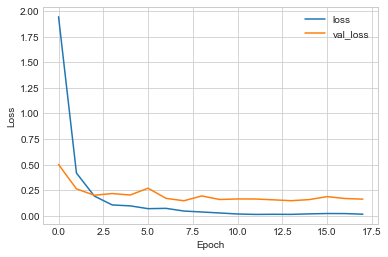

2/2 [==============================] - 0s 2ms/step


<Figure size 432x288 with 0 Axes>

In [12]:
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid")

# Do prediction n_iter times =============================================================
n_iter = 5

# Results list (of Series)
res_list = []
# Prediction dictionary (by trait) which contains lists (of dataframes)
prediction_dict = {}
for i in range(len(traits)):
    prediction_dict[traits[i]] = []


# For each iteration
for iter in range(n_iter):

    # Create model from hypermodel class #################################################
    model = hypermodel.build(best_hps)
    # model.summary()
    
    # Training with early stopping. Use validation set ###################################
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = "val_loss",
            patience = 10,
            min_delta = 0.001,
            restore_best_weights = True
        )
    ]

    history = hypermodel.fit(
        best_hps, model,
        x = X_train_sub, y = y_train_sub,
        epochs = 50,
        callbacks = callbacks,
        validation_data = (X_val, y_val),
        verbose = 2
    )

    # Training plot
    plt.plot(history.history["loss"], label = "loss")
    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.legend(loc = "upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig(os.path.join(pred_path, f"training_loss_plot_{iter}.png"), dpi = 300)
    plt.show()
    plt.clf()

    # Save prediction results ############################################################
    
    # Compute metrics and prediction
    eval_result = model.evaluate(x = X_test, y = y_test, return_dict = True)
    pred_result = model.predict(X_test)

    # Series of results
    res = pd.Series(eval_result)

    # Dataset size
    size_train = y_train[traits[0]].shape[0]
    size_test = y_test[traits[0]].shape[0]
    size_total = size_train + size_test

    res["size_train"] = size_train
    res["size_test"] = size_test
    res["size_total"] = size_total

    # Compute extra metrics, depending on target type

    for i in range(len(target_types)):
        y_test_i = y_test[traits[i]]
        
        if target_types[i] == "continuous":
            # Correlation
            if output_type == "single-output":
                pred_result_i = pred_result
            else:
                pred_result_i = pred_result[i]
            
            y_hat = pred_result_i
            cor = np.corrcoef(y_test_i, y_hat, rowvar = False)[0, 1]
            res[f"{traits[i]}_cor"] = cor
            
        elif target_types[i] == "binary":
            # AUC
            if output_type == "single-output":
                pred_result_i = pred_result
            else:
                pred_result_i = pred_result[i]
            m = keras.metrics.AUC()
            m.update_state(y_test_i, pred_result_i)
            AUC = m.result().numpy()
            res[f"{traits[i]}_AUC"] = AUC
            
        # Save prediction just in case
        prediction = pd.DataFrame({
            "original_index": test_mask.index[test_mask == True],
            "prediction": pred_result_i.squeeze() 
        })
        # Prediction to dict (in list)
        prediction_dict[traits[i]].append(prediction)
    
    # Results to list
    res_list.append(res)

In [13]:
# Compute average results from res_list ==================================================

# Join res in dataframe
res_df = pd.DataFrame(columns = res_list[0].index)

for i in range(len(res_list)):
    series = res_list[i]
    res_df.loc[i, ] = series

# Compute mean and sd
RES = pd.DataFrame({
    "mean": res_df.mean(),
    "sd": res_df.std()
})
print(RES)

RES.to_csv(os.path.join(pred_path, "results.csv"), index = True, header = True)

                        mean        sd
loss                1.090673  0.283655
mse                 1.090673  0.283655
size_train        607.000000  0.000000
size_test          34.000000  0.000000
size_total        641.000000  0.000000
grain.weight_cor    0.090682  0.222854


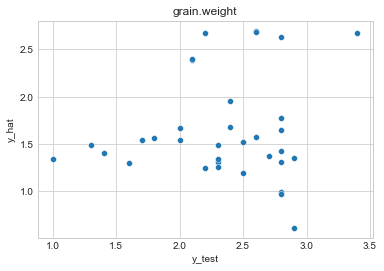

<Figure size 432x288 with 0 Axes>

In [14]:
# Compute average prediction from prediction_dict ========================================

# For each trait
for i in range(len(traits)):
    # Get list, and join predictions into dataframe
    prediction_list = prediction_dict[traits[i]]
    prediction_df = pd.DataFrame(columns = prediction_list[0]["original_index"])

    for j in range(len(prediction_list)):
        series = prediction_list[j]
        series.index = series["original_index"]
        series = series["prediction"]
        prediction_df.loc[j, ] = series
    
    # Compute mean and sd
    PREDICTION = pd.DataFrame({
        "original_index": prediction_df.columns,
        "mean": prediction_df.mean(),
        "sd": prediction_df.std()
    })
    # print(PREDICTION)
    
    PREDICTION.to_csv(os.path.join(pred_path, f"prediction_{traits[i]}.csv"),
                      index = False, header = True)
    
    
    # Make plots of predictions
    y_test_i = y_test[traits[i]]
        
    if target_types[i] == "continuous":
        
        pred_result_i = PREDICTION["mean"]
        y_hat = pred_result_i
        
        # Correlation plot
        plot = sns.scatterplot(x = y_test_i.squeeze(), y = y_hat.squeeze())
        plot.set(xlabel = "y_test", ylabel = "y_hat", title = traits[i])
        plt.savefig(os.path.join(pred_path, f"cor_plot_{traits[i]}.png"), dpi = 300)
        plt.show()
        plt.clf()
    
    elif target_types[i] == "binary":
        
        pred_result_i = PREDICTION["mean"]
        
        # Confusion matrix plot
        y_hat = np.where(pred_result_i > 0.5, 1, 0)
        conf = confusion_matrix(y_test_i, y_hat)
        plot = sns.heatmap(conf, annot = True, cmap = "Blues")
        plot.set(xlabel = "y_hat", ylabel = "y_test", title = traits[i])
        plt.savefig(os.path.join(pred_path, f"conf_matrix_{traits[i]}.png"), dpi = 300)
        plt.show()
        plt.clf()